## Import Packages

In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf
from tqdm import tqdm

In [2]:
class_names = ['bali', 'megamendung', 'sidomukti']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

## Loading the Data
Menulis fungsi load_data yang memuat gambar dan label dari folder.

In [3]:
def load_data():
    
    datasets = ['dataset/sets_train', 'dataset/sets_test']
    output = []
    
    # Iterasi melalui pelatihan dan set tes
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterasi setiap folder yang sesuai dengan kategori
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterasi setiap gambar di tiap folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Dapatkan nama path gambar
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Buka dan ubah ukuran img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Tambahkan gambar dan label yang sesuai ke output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading dataset/sets_train


100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 117.19it/s]


Loading dataset/sets_test


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 159.20it/s]


In [5]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

## Exploratory dataset

In [6]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Jumlah contoh pelatihan (train): {}".format(n_train))
print ("Jumlah contoh pengujian (test): {}".format(n_test))
print ("Setiap gambar memiliki ukuran: {}".format(IMAGE_SIZE))

Jumlah contoh pelatihan (train): 387
Jumlah contoh pengujian (test): 24
Setiap gambar memiliki ukuran: (150, 150)


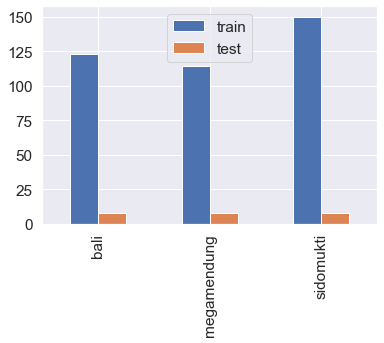

In [7]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
              'test': test_counts},
             index=class_names
            ).plot.bar()
plt.show()

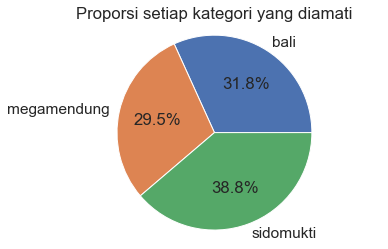

In [8]:
plt.pie(train_counts,
        explode=(0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proporsi setiap kategori yang diamati')
plt.show()

## Scale the data

In [9]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

## Visualize the data
Menampilkan gambar acak dari set pelatihan.

In [10]:
def display_random_image(class_names, images, labels):
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

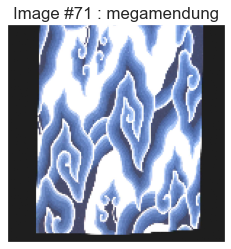

In [11]:
display_random_image(class_names, train_images, train_labels)

Juga bisa menampilkan 10 gambar pertama dari set pelatihan secara langsung dengan loop untuk mendapatkan tampilan yang lebih baik

In [12]:
def display_examples(class_names, images, labels):
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Beberapa contoh gambar dari dataset", fontsize=16)
    for i in range(10):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

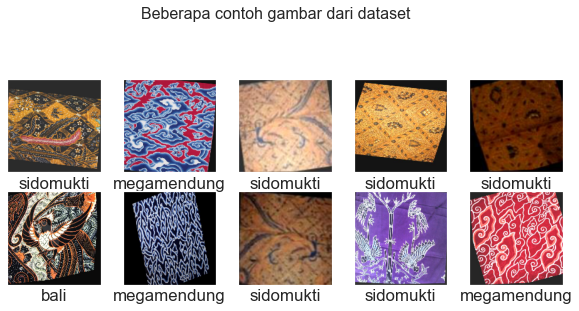

In [13]:
display_examples(class_names, train_images, train_labels)

# Simple Model Creation

Kita dapat membangun model sederhana terdiri dari lapisan yang berbeda seperti:
* Conv2D: (32 filter ukuran 3 kali 3) Fitur akan "diekstraksi" dari gambar.
* MaxPooling2D: Gambar menjadi setengah ukuran.
* Flatten: Mengubah format gambar dari array 2d ke array 1d dengan nilai 150 150 3 piksel.
* Relu : diberi nilai x, mengembalikan max(x, 0).
* Softmax: 6 neuron, probabilitas bahwa gambar termasuk dalam salah satu kelas.

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [15]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

Mengaplikasikan model dengan data dari set pelatihan. Jaringan saraf akan mempelajari sendiri pola tersebut untuk membedakan setiap kategori.

In [16]:
history = model.fit(train_images, train_labels, batch_size=32, epochs=20, validation_split = 0.2)

Epoch 1/20
10/10 [==============================] - 5s 510ms/step - loss: 3.0076 - accuracy: 0.3754 - val_loss: 1.2090 - val_accuracy: 0.3974
Epoch 2/20
10/10 [==============================] - 5s 491ms/step - loss: 1.0623 - accuracy: 0.6019 - val_loss: 0.7398 - val_accuracy: 0.7179
Epoch 3/20
10/10 [==============================] - 5s 474ms/step - loss: 0.7873 - accuracy: 0.7184 - val_loss: 0.6574 - val_accuracy: 0.7179
Epoch 4/20
10/10 [==============================] - 5s 490ms/step - loss: 0.6120 - accuracy: 0.7638 - val_loss: 0.6009 - val_accuracy: 0.7436
Epoch 5/20
10/10 [==============================] - 5s 466ms/step - loss: 0.4447 - accuracy: 0.8220 - val_loss: 0.5549 - val_accuracy: 0.7564
Epoch 6/20
10/10 [==============================] - 5s 467ms/step - loss: 0.3613 - accuracy: 0.8447 - val_loss: 0.5111 - val_accuracy: 0.7949
Epoch 7/20
10/10 [==============================] - 5s 457ms/step - loss: 0.2549 - accuracy: 0.9159 - val_loss: 0.4660 - val_accuracy: 0.8077
Epoch 

In [17]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

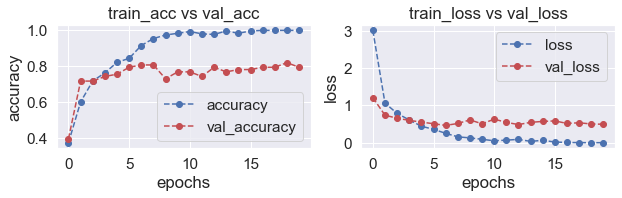

In [18]:
plot_accuracy_loss(history)

Mengevaluasi kinerja model pada set pengujian

In [19]:
test_loss = model.evaluate(test_images, test_labels)

1/1 [==============================] - 0s 5ms/step - loss: 0.7619 - accuracy: 0.7500


Kinerja classifier pada gambar acak pada gambar yang dijadikan test.

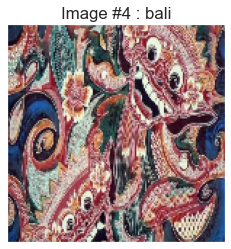

In [33]:
predictions = model.predict(test_images)     # Vektor probabilitas
pred_labels = np.argmax(predictions, axis = 1) # Diambil probabilitas tertinggi

display_random_image(class_names, test_images, pred_labels)

## Error analysis

Kita dapat mencoba memahami jenis gambar mana yang bermasalah oleh pengklasifikasi.

In [34]:
def display_errors(class_names, images, labels):
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Beberapa contoh gambar dari dataset", fontsize=16)
    for i in range(5):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

In [35]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):

    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Beberapa contoh gambar yang salah diberi label oleh pengklasifikasi:"
    display_errors(class_names, mislabeled_images, mislabeled_labels)


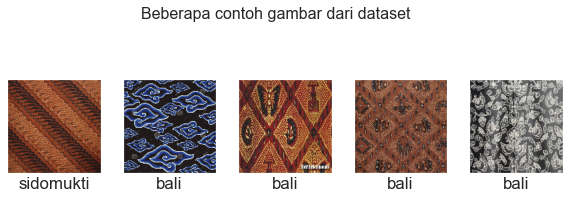

In [36]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

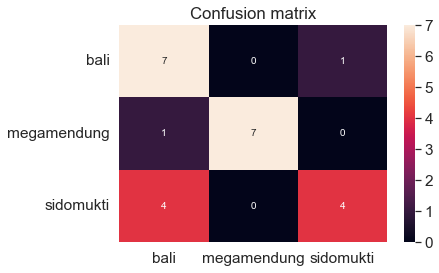

In [37]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

# Feature extraction with VGG ImageNet

Mendapatkan fitur langsung dari VGG16

In [38]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

In [39]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

## Visualize the features through PCA

In [40]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

In [41]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X)
C1 = C[:,0]
C2 = C[:,1]

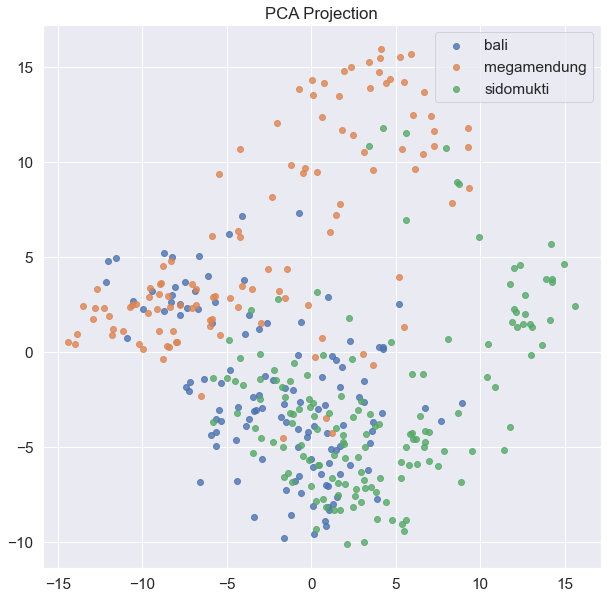

In [42]:
plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label = class_name, alpha=0.8)
plt.legend()
plt.title("PCA Projection")
plt.show()

## Training on top of VGG

Melatih Neural Network satu lapis sederhana pada fitur yang diekstrak dari VGG.

In [43]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(train_features, train_labels, batch_size=32, epochs=15, validation_split = 0.2)

Epoch 1/15
10/10 [==============================] - 0s 19ms/step - loss: 0.9464 - accuracy: 0.5825 - val_loss: 0.3892 - val_accuracy: 0.8333
Epoch 2/15
10/10 [==============================] - 0s 8ms/step - loss: 0.3029 - accuracy: 0.8997 - val_loss: 0.2466 - val_accuracy: 0.8974
Epoch 3/15
10/10 [==============================] - 0s 7ms/step - loss: 0.1621 - accuracy: 0.9482 - val_loss: 0.1851 - val_accuracy: 0.9487
Epoch 4/15
10/10 [==============================] - 0s 6ms/step - loss: 0.0723 - accuracy: 0.9871 - val_loss: 0.1409 - val_accuracy: 0.9487
Epoch 5/15
10/10 [==============================] - 0s 8ms/step - loss: 0.0466 - accuracy: 0.9935 - val_loss: 0.2363 - val_accuracy: 0.9103
Epoch 6/15
10/10 [==============================] - 0s 5ms/step - loss: 0.0357 - accuracy: 0.9968 - val_loss: 0.1179 - val_accuracy: 0.9615
Epoch 7/15
10/10 [==============================] - 0s 9ms/step - loss: 0.0234 - accuracy: 0.9968 - val_loss: 0.1182 - val_accuracy: 0.9615
Epoch 8/15
10/10 [=

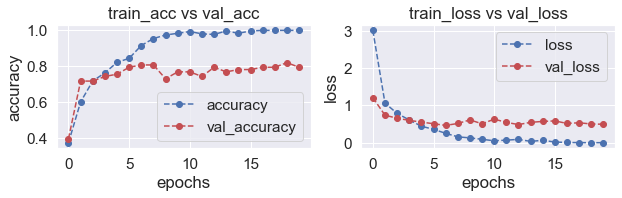

In [44]:
plot_accuracy_loss(history)

In [45]:
test_loss = model2.evaluate(test_features, test_labels)

1/1 [==============================] - 0s 0s/step - loss: 0.7219 - accuracy: 0.7917
